In [8]:
import keras
from sklearn.model_selection import train_test_split
from random import randint
from numpy import array
from numpy import argmax
from keras import models
from numpy import array_equal
import numpy as np
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Flatten
from keras import Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
import scipy
from scipy.signal import filtfilt

from keras.layers import Lambda
from keras import backend as K

keras.backend.set_floatx('float64')

In [9]:
def highPassFilter(signal, cutValue):
    fs = len(signal)

# de salida 
    lowcut= 20
    highcut= cutValue

    nyq= fs
    low= lowcut / nyq
    high= highcut / nyq

    order = 2

    b, a= scipy.signal.butter(2, high, btype='high',analog= False)
    y= filtfilt(b,a, signal)
    return y

In [12]:
def hotEncode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

(2200, 50)


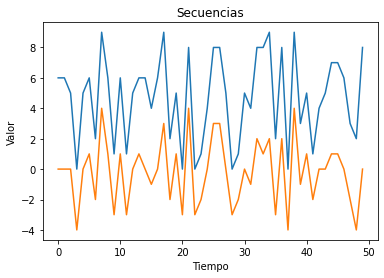

In [15]:
lv= 0
hv= 10
size= 50
dataSize= 2200
cutValue= 10
data= {}
signalA=[]
signalB=[]




for i in range(dataSize):
    mainSignal= np.random.randint(lv,hv, size=(size))
    
    lpSignal= highPassFilter(mainSignal,cutValue)
    
    signalA.append(mainSignal)
    signalB.append(lpSignal)




signalA = np.array(signalA)
signalB = np.array(signalB, dtype='int')
# signalB = np.absolute(signalB.astype(int)) 

print(signalA.shape)


plt.plot(signalA[0])
plt.plot(signalB[0])
plt.title("Secuencias")
plt.xlabel('Tiempo') 
plt.ylabel('Valor') 
plt.show() 



In [16]:
input_main_signal = signalA
input_lp_signal = signalB


mainSignalTrain, mainSignalTest,lpSignalTrain,lpSignalTest= train_test_split( input_lp_signal,input_main_signal,test_size=0.0906)



X_train, Y_train, X_val, Y_val = [],[],[],[]

for i in range(len(mainSignalTrain)):
    X_train.append(hotEncode(mainSignalTrain[i],hv))
    Y_train.append(hotEncode(lpSignalTrain[i],hv))
for j in range(len(mainSignalTest)):
    X_val.append(hotEncode(mainSignalTest[j],hv))
    Y_val.append(hotEncode(lpSignalTest[j],hv))
    
X_train= np.array(X_train)
Y_train= np.array(Y_train)
X_val= np.array(X_val)
Y_val= np.array(Y_val)

print(X_train.shape)


(2000, 50, 10)


In [ ]:
numberOfLSTMunits= 100
batch_size = 10
verbose= 1
encoder_inputs = Input(shape=(size, hv), name='encoder_inputs')
encoder_lstm = LSTM(numberOfLSTMunits, return_state=True,  name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  

states = [state_h, state_c]
  
decoder_inputs = Input(shape=(1, hv))
decoder_lstm = LSTM(numberOfLSTMunits, return_sequences=True, 
                        return_state=True, name='decoder_lstm')
decoder_dense = Dense(hv, activation='softmax',  name='decoder_dense')

all_outputs = []

decoder_input_data = np.zeros((batch_size, 1, hv))
decoder_input_data[:, 0, 0] = 1 
    

inputs = decoder_input_data

for _ in range(size):
        # Run the decoder on one time step
    outputs, state_h, state_c = decoder_lstm(inputs,
                                                initial_state=states)
    outputs = decoder_dense(outputs)
        # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
        # Reinject the outputs as inputs for the next loop iteration
        # as well as update the states
    inputs = outputs
    
    states = [state_h, state_c]

decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

model = keras.Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history=model.fit(X_train, Y_train, validation_split= 0.1, epochs=100,batch_size=batch_size, verbose=verbose)


Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 50, 10)]     0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 100),        44400       ['encoder_inputs[0][0]']         
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 decoder_lstm (LSTM)            [(10, 1, 100),       44400       ['encoder_lstm[0][1]',           
                                 (None, 100),                     'encoder_lst

                                                                  'decoder_dense[24][0]',         
                                                                  'decoder_lstm[24][1]',          
                                                                  'decoder_lstm[24][2]',          
                                                                  'decoder_dense[25][0]',         
                                                                  'decoder_lstm[25][1]',          
                                                                  'decoder_lstm[25][2]',          
                                                                  'decoder_dense[26][0]',         
                                                                  'decoder_lstm[26][1]',          
                                                                  'decoder_lstm[26][2]',          
                                                                  'decoder_dense[27][0]',         
          

                                                                  'decoder_lstm[7][0]',           
                                                                  'decoder_lstm[8][0]',           
                                                                  'decoder_lstm[9][0]',           
                                                                  'decoder_lstm[10][0]',          
                                                                  'decoder_lstm[11][0]',          
                                                                  'decoder_lstm[12][0]',          
                                                                  'decoder_lstm[13][0]',          
                                                                  'decoder_lstm[14][0]',          
                                                                  'decoder_lstm[15][0]',          
                                                                  'decoder_lstm[16][0]',          
          

                                                                  'decoder_dense[39][0]',         
                                                                  'decoder_dense[40][0]',         
                                                                  'decoder_dense[41][0]',         
                                                                  'decoder_dense[42][0]',         
                                                                  'decoder_dense[43][0]',         
                                                                  'decoder_dense[44][0]',         
                                                                  'decoder_dense[45][0]',         
                                                                  'decoder_dense[46][0]',         
                                                                  'decoder_dense[47][0]',         
                                                                  'decoder_dense[48][0]',         
          

Epoch 47/100
 68/180 [==========>...................] - ETA: 41s - loss: 2.2172 - accuracy: 0.1590

In [22]:
model.evaluate(X_val, Y_val)

InvalidArgumentError: Graph execution error:

Detected at node 'while/add' defined at (most recent call last):
    File "C:\Users\arval\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\arval\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\arval\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\arval\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\arval\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\arval\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\arval\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\arval\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\arval\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\arval\AppData\Local\Temp\ipykernel_3712\2329663574.py", line 1, in <cell line: 1>
      model.evaluate(X_val, Y_val)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\layers\rnn\base_rnn.py", line 573, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 673, in call
      runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 1183, in lstm_with_backend_selection
      last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(**params)
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 891, in standard_lstm
      last_output, outputs, new_states = backend.rnn(
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\backend.py", line 4776, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\backend.py", line 4759, in _step
      output, new_states = step_function(current_input,
    File "C:\Users\arval\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 878, in step
      z += backend.dot(h_tm1, recurrent_kernel)
Node: 'while/add'
Incompatible shapes: [10,64] vs. [32,64]
	 [[{{node while/add}}]]
	 [[model_encoder_decoder/decoder_lstm/PartitionedCall]] [Op:__inference_test_function_593808]